<a href="https://colab.research.google.com/github/ATOMScience-org/AMPL/blob/master/atomsci/ddm/examples/tutorials/14_BSEP_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BSEP Inhibition Model Creation and Prediction
The data source is https://github.com/ATOMScience-org/AMPL/tree/master/atomsci/ddm/examples/BSEP.  

The notebook is based on the modeling procedure published in the following manscript, https://pubmed.ncbi.nlm.nih.gov/33502191/, and provides AMPL code to create/test Random Forest (RF) model. The notebook ends by testing the RF model using an external test data. Please note the datasets used in this notebook came from AMPL github site.  

# Basic biology of BSEP gene
You can read about BSEP gene here, 

https://en.wikipedia.org/wiki/ABCB11

and/or here,

http://useast.ensembl.org/Homo_sapiens/Gene/Summary?db=core;g=ENSG00000276582;r=CHR_HSCHR2_1_CTG7_2:168939927-168953422 

BSEP or ABCB11 is a gene associated with the disease progressive familial intrahepatic cholestasis type 2 (PFIC2).PFIC2 is shown to be caused by mutations in the ABCB11 gene which increases the risk of hepatocellular carcinoma in early life.




The notebook will run through the following steps: 

1.   Clone the AMPL git repository and install the software  
2.   Use a data file from AMPL repository as input
3.   Split the data 
4.   Train a model
5.   Show how you can make predictions on the model.   
6.   If you want to use your input data, please make sure your input data should be in CSV format that contains the following information: 
        *   Row of column headers
        *   contain a column of SMILES strings for the compounds you want to run predictions on.
        * Optional information: 
                *   A column of unique compound IDs; if none is provided, one will be generated for you
                *   A column of binary activity values, if you have measured IC50s for the input compounds: 0 if the IC50 < 100 uM, 1 if IC50 >= 100 uM.

## Here is a sample input dataset with four componds

|base_rdkit_smiles | compound_name| pIC50 |relation|active |
|------------------|------------|-------|--------|-------|
|CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C3C(=O)c4c(O)cccc4[C@@](C)(O)C3CC12"	|CHEMBL198	|3.000000	|<	|0 |
|C[C@]12C[C@H](O)[C@@]3(F)C(CCC4=CC(=O)C=C[C@@]43C)C1C[C@@H](O)[C@]2(O)C(=O)CO|CHEMBL3039453	|3.627825	|NaN	|1 |
|Nc1nc2cc(Cl)ccc2o1	|CHEMBL472566	|3.000000	|< |0|
|COc1cc([C@@H]2c3cc4c(cc3[C@@H](O[C@@H]3O[C@@H]5CO[C@@H](C)O[C@H]5[C@H](O)[C@H]3O)[C@H]3COC(=O)[C@H]23)OCO4)cc(OC)c1O	|CHEMBL44657	|3.876148	|<|	0 |



## Before you begin, make sure you close all other COLAB notebooks. 

# Change Runtime settings

## Plesae change your runtime settings to use GPU and high-memory, if you have 

## Runtime --> Change Runtime Type --> GPU

In [1]:
!date # starting time

Sat Sep 18 16:06:10 UTC 2021


# AMPL Installation

In [ ]:
! pip install rdkit-pypi
! pip install deepchem

import deepchem
# print(deepchem.__version__)
! pip install umap
! pip install -U --ignore-installed numba
! pip install umap-learn
! pip install molvs
! pip install bravado

In [ ]:
import deepchem as dc

# get the Install AMPL_GPU_test.sh
! wget 'https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/tutorials/config/install_AMPL_GPU_test.sh' >& /dev/null

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

In [ ]:
# Obtain the files from GitHub
! wget https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/BSEP/data/small_test_data.csv 
! wget https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/BSEP/data/morgan_warner_combined_bsep_data.csv

# Load the libraries

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_context("poster")
sns.set_style("whitegrid")
sns.set_palette("Set2")

import pandas as pd
import os, json, sys, glob, pickle

from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse
from atomsci.ddm.pipeline import perf_data

2021-09-18 16:07:44,504 Model tracker client not supported in your environment; will save models in filesystem only.


# Load the Data

In [6]:
df = pd.read_csv("morgan_warner_combined_bsep_data.csv")

In [7]:
df.head(3)

,compound_name,source,base_rdkit_smiles,relation,pIC50,active
0,fenoximone,Morgan,CSc1ccc(C(=O)c2[nH]c(=O)[nH]c2C)cc1,<,3.876148,0
1,OXEDRINE,Warner,CNCC(O)c1ccc(O)cc1,<,3.000000,0
2,ccl4,Morgan,ClC(Cl)(Cl)Cl,<,3.876148,0


## Display some molecules

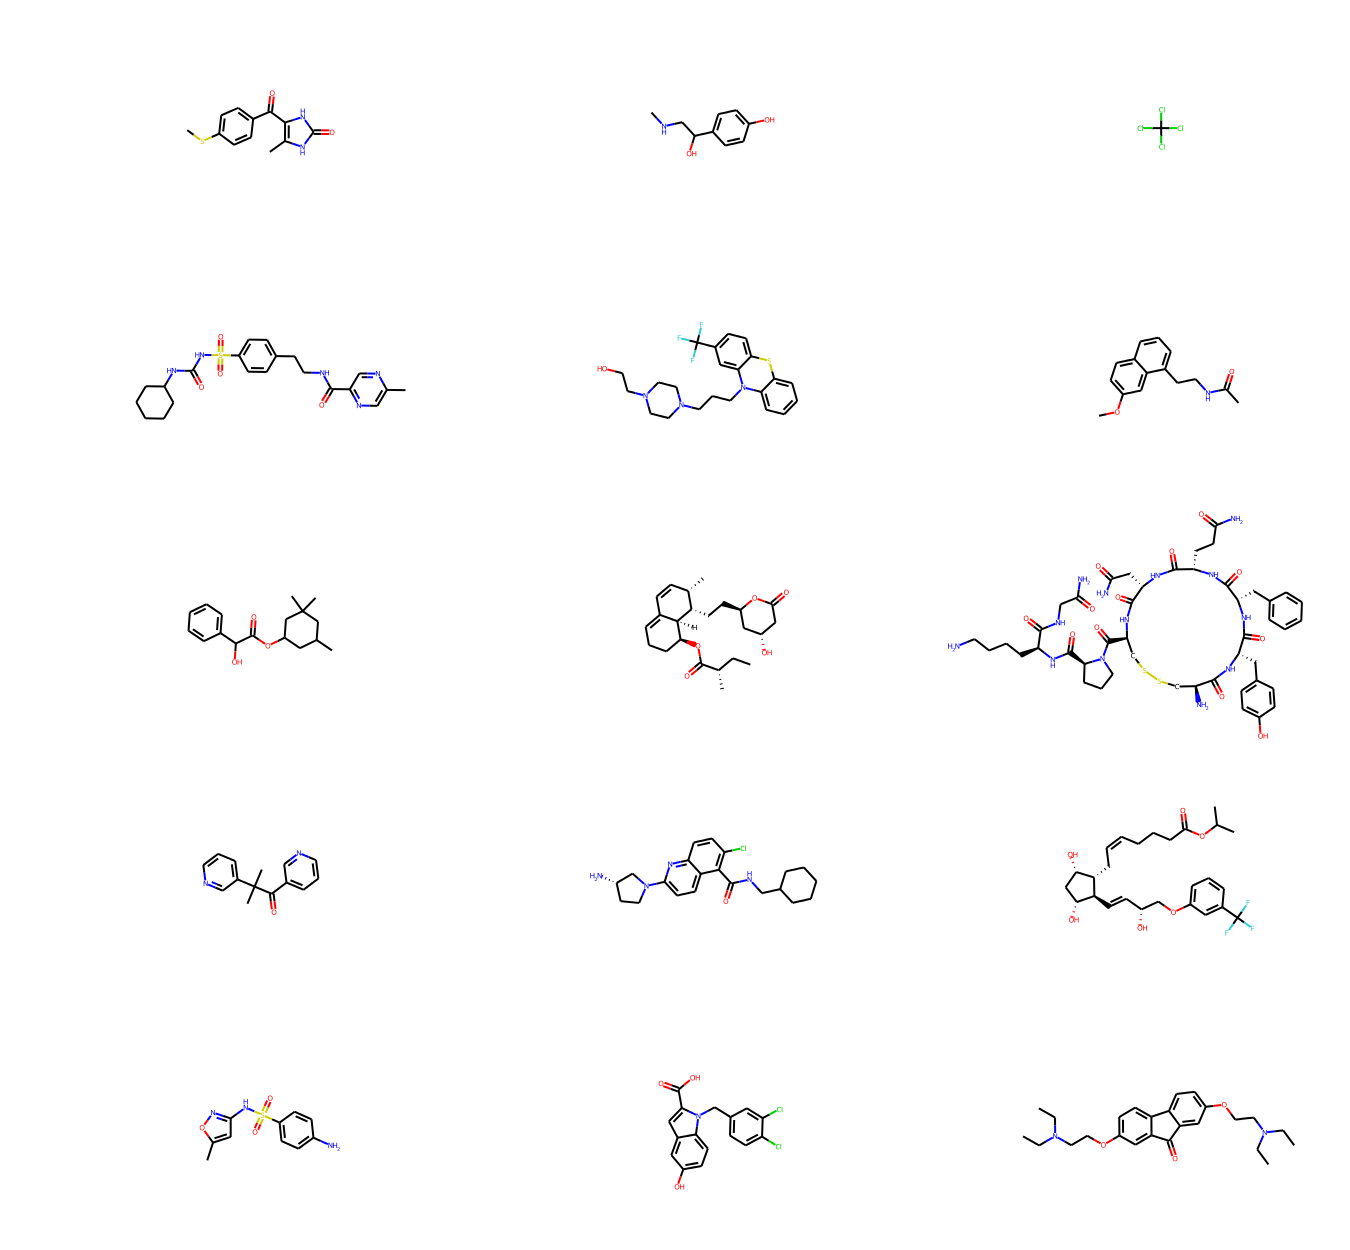

In [8]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from itertools import islice

#Needed to show molecules
from rdkit.Chem.Draw import IPythonConsole 

from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions 
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole


molecules = [Chem.MolFromSmiles(smiles)
             for smiles in islice(df['base_rdkit_smiles'],15)]

Draw.MolsToGridImage(molecules,  subImgSize=(450,250))

# Modeling: Training

In [9]:
response_col = "active"
compound_id = "compound_name"
smiles_col = "base_rdkit_smiles"

params = {
        "verbose": "True",
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "classification",
        "dataset_key": "/content/morgan_warner_combined_bsep_data.csv",
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "previously_split": "False",
        "split_only": "False",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "/content"
        # "ampl_version": " "
    }

ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

2021-09-18 16:07:44,834 Attempting to load featurized dataset
2021-09-18 16:07:44,843 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2021-09-18 16:07:44,845 Featurized dataset not previously saved for dataset morgan_warner_combined_bsep_data, creating new
2021-09-18 16:07:44,858 Featurizing sample 0
2021-09-18 16:07:49,246 Splitting data by scaffold


number of features: 1024


2021-09-18 16:07:49,687 Dataset split table saved to /content/morgan_warner_combined_bsep_data_train_valid_test_scaffold_8400760b-9111-466a-b23c-824bd0c3ed4c.csv
2021-09-18 16:07:49,720 Fitting random forest model
2021-09-18 16:07:52,206 Fold 0: training roc_auc_score = 1.000, validation roc_auc_score = 0.795, test roc_auc_score = 0.747
2021-09-18 16:07:52,741 Wrote model tarball to /content/morgan_warner_combined_bsep_data_model_b2172bb4-2e81-401e-9d81-0a2b9a5bb53a.tar.gz


# Explore the model tar and metadata files 

In [10]:
!tar -tf *.tar.gz

./best_model/
./best_model/model.joblib
./model_metadata.json
./model_metrics.json


In [11]:
!tar xzf *.tar.gz -C /tmp

In [12]:
!cat /tmp/model_metadata.json | head

{
    "ecfp_specific": {
        "ecfp_radius": 2,
        "ecfp_size": 1024
    },
    "model_parameters": {
        "ampl_version": "1.2.0",
        "featurizer": "ecfp",
        "hyperparam_uuid": null,
        "model_bucket": "public",


In [13]:
import joblib
# load the model from disk
loaded_model = joblib.load("/tmp/best_model/model.joblib")
loaded_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=32,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [14]:
import json
import pandas as pd
data = json.load(open('/tmp/model_metadata.json'))
# pd.DataFrame(data["model_parameters"])
data['model_parameters']

{'ampl_version': '1.2.0',
 'featurizer': 'ecfp',
 'hyperparam_uuid': None,
 'model_bucket': 'public',
 'model_choice_score_type': 'roc_auc',
 'model_type': 'RF',
 'num_model_tasks': 1,
 'prediction_type': 'classification',
 'save_results': False,
 'system': 'LC',
 'time_generated': 1631981272.6411622,
 'transformer_bucket': 'public',
 'transformer_key': None,
 'transformer_oid': None,
 'transformers': True,
 'uncertainty': True}

# Make a prediction on the validation test

In [15]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
pred_results
print(f"AUC score of validation set: {pred_results['prc_auc_score']:.3f}")

AUC score of validation set: 0.743


In [16]:
pred_data = pl.model_wrapper.get_perf_data(subset="test", epoch_label="best")
pred_results = pred_data.get_prediction_results()
# print(f"R2 score of validation set: {pred_results['r2_score']:.3f}")

In [17]:
pred_results

{'accuracy_score': 0.696969696969697,
 'bal_accuracy': 0.6948529411764706,
 'confusion_matrix': [[[26, 8], [12, 20]]],
 'cross_entropy': 0.5918038827402821,
 'kappa': 0.3911439114391144,
 'matthews_cc': 0.39407655228132893,
 'npv': 0.6842105263157895,
 'num_compounds': 66,
 'prc_auc_score': 0.7296276022625086,
 'precision': 0.7142857142857143,
 'recall_score': 0.625,
 'roc_auc_score': 0.7472426470588235}

# Use an external data set for prediction
If you want to use your input data, please make sure your input data should be in CSV format that contains the following information:
Row of column headers
contain a column of SMILES strings for the compounds you want to run predictions on.
Optional information:
  *   A column of unique compound IDs; if none is provided, one will be generated for you
  *   A column of binary activity values, if you have measured IC50s for the input compounds: 0 if the IC50 < 100 uM, 1 if IC50 >= 100 uM.

Let us read a sample test data and make predictions.


In [18]:
test_data = pd.read_csv("small_test_data.csv")
test_data.head(4)

,base_rdkit_smiles,compound_id,pIC50,relation,active
0,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,CHEMBL198,3.000000,<,0
1,C[C@]12C[C@H](O)[C@@]3(F)C(CCC4=CC(=O)C=C[C@@]...,CHEMBL3039453,3.627825,NaN,1
2,Nc1nc2cc(Cl)ccc2o1,CHEMBL472566,3.000000,<,0
3,COc1cc([C@@H]2c3cc4c(cc3[C@@H](O[C@@H]3O[C@@H]...,CHEMBL44657,3.876148,<,0


In [19]:
# ?pl.predict_on_smiles
list_cpds = list(test_data.base_rdkit_smiles.values)

In [20]:
test_data.rename(columns={"compound_id": "compound_name"}, inplace=True)
test_data.head(5)

,base_rdkit_smiles,compound_name,pIC50,relation,active
0,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,CHEMBL198,3.000000,<,0
1,C[C@]12C[C@H](O)[C@@]3(F)C(CCC4=CC(=O)C=C[C@@]...,CHEMBL3039453,3.627825,NaN,1
2,Nc1nc2cc(Cl)ccc2o1,CHEMBL472566,3.000000,<,0
3,COc1cc([C@@H]2c3cc4c(cc3[C@@H](O[C@@H]3O[C@@H]...,CHEMBL44657,3.876148,<,0
4,CC(=O)[C@H]1[C@H](C#N)C[C@H]2[C@@H]3CC=C4CC(O)...,CHEMBL4063685,3.876148,<,0


# Inference on the external dataset

In [21]:
results_df = pl.predict_on_dataframe(test_data, contains_responses=True)
results_df

2021-09-18 16:07:53,729 Featurizing data...
2021-09-18 16:07:53,738 Featurizing sample 0
2021-09-18 16:07:53,890 Done
2021-09-18 16:07:53,905 Evaluating current model


number of features: 1024


,base_rdkit_smiles,actual,pred
compound_name,,,
CHEMBL198,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,0.0,0
CHEMBL3039453,C[C@]12C[C@H](O)[C@@]3(F)C(CCC4=CC(=O)C=C[C@@]...,1.0,0
CHEMBL472566,Nc1nc2cc(Cl)ccc2o1,0.0,0
CHEMBL44657,COc1cc([C@@H]2c3cc4c(cc3[C@@H](O[C@@H]3O[C@@H]...,0.0,1
CHEMBL4063685,CC(=O)[C@H]1[C@H](C#N)C[C@H]2[C@@H]3CC=C4CC(O)...,0.0,1
CHEMBL1200777,N[C@H](Cc1cc(I)c(Oc2cc(I)c(O)c(I)c2)c(I)c1)C(=...,1.0,1
CHEMBL452231,COc1cc([C@@H]2c3cc4c(cc3[C@@H](O[C@@H]3O[C@@H]...,0.0,1
CHEMBL640,CCN(CC)CCNC(=O)c1ccc(N)cc1,0.0,0
CHEMBL95804,CCN(CC)CCNC(=O)c1ccc(NS(C)(=O)=O)cc1,0.0,0


### New AMPL version function can be used instead of the previous cell command

In [22]:
import os
files = os.listdir()
for f in files: 
  if (f.endswith(".tar.gz")):
    mfile = f 

print(mfile)

morgan_warner_combined_bsep_data_model_b2172bb4-2e81-401e-9d81-0a2b9a5bb53a.tar.gz


## Replace the mfile with the file that is shown above. Note the filename will be different for each run 

In [23]:
from atomsci.ddm.pipeline import predict_from_model as pfm
# mfile = "morgan_warner_combined_bsep_data_model_c6623e4c-b43c-404d-9bd7-59b86fa138bc.tar.gz"
mpath = '/content'
input_df = test_data
response_col = "active"
smiles_col = "base_rdkit_smiles"
pfm.predict_from_model_file(model_path = mfile, 
                            input_df = input_df, 
                            smiles_col = smiles_col, 
                            response_col = response_col)

Standardizing SMILES strings for 19 compounds.


2021-09-18 16:07:54,645 ['ampl_version', 'time_generated', 'time_built', 'dataset_metadata', 'training_metrics'] are not part of the accepted list of parameters and will be ignored


Featurization = DynamicFeaturization with ecfp features
number of features: 1024


,compound_id,standardized_smiles,active_actual,active_prob,active_pred
0,compound_000000,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,0.0,0.317333,0
1,compound_000001,C[C@]12C[C@H](O)[C@@]3(F)C(CCC4=CC(=O)C=C[C@@]...,1.0,0.262000,0
2,compound_000002,Nc1nc2cc(Cl)ccc2o1,0.0,0.296000,0
3,compound_000003,COc1cc([C@@H]2c3cc4c(cc3[C@@H](O[C@@H]3O[C@@H]...,0.0,0.513417,1
4,compound_000004,CC(=O)[C@H]1[C@H](C#N)C[C@H]2[C@@H]3CC=C4CC(O)...,0.0,0.743000,1
5,compound_000005,N[C@H](Cc1cc(I)c(Oc2cc(I)c(O)c(I)c2)c(I)c1)C(=...,1.0,0.800000,1
6,compound_000006,COc1cc([C@@H]2c3cc4c(cc3[C@@H](O[C@@H]3O[C@@H]...,0.0,0.522000,1
7,compound_000007,CCN(CC)CCNC(=O)c1ccc(N)cc1,0.0,0.134000,0
8,compound_000008,CCN(CC)CCNC(=O)c1ccc(NS(C)(=O)=O)cc1,0.0,0.260000,0
9,compound_000009,O=C(O)CCNC(=O)c1ccccc1,0.0,0.118000,0


# Report some performance metrics

In [24]:
from sklearn.metrics import balanced_accuracy_score
y_true = results_df['actual'].values
y_pred = results_df['pred'].values
balanced_accuracy_score(y_true, y_pred)

0.4571428571428572

In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[10,  4],
       [ 4,  1]])

In [26]:
!date

Sat Sep 18 16:07:55 UTC 2021
